In [13]:
%matplotlib inline

from preamble import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

StandardScaler(copy=True, with_mean=True, with_std=True)

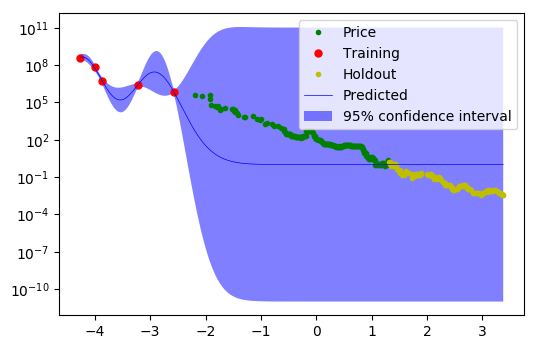

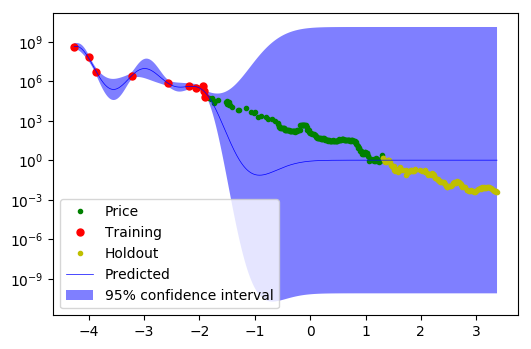

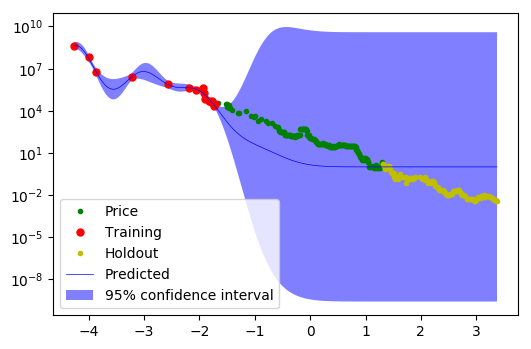

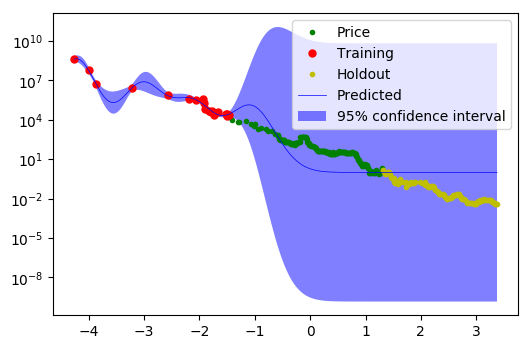

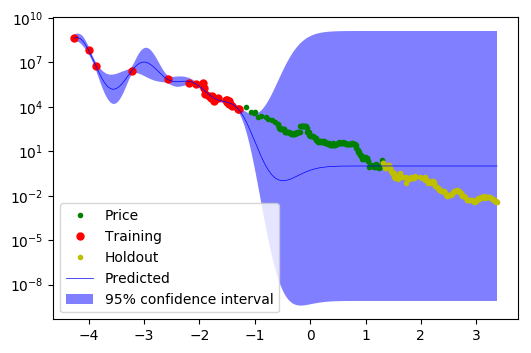

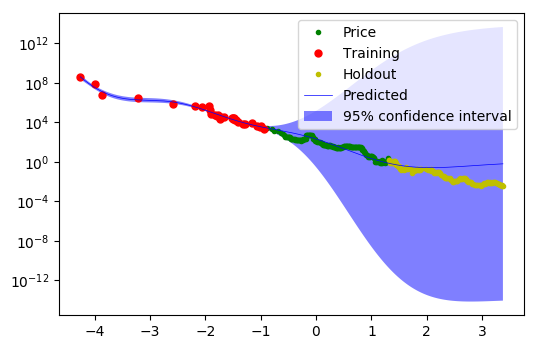

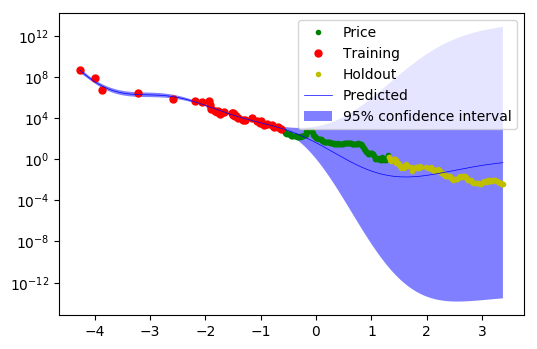

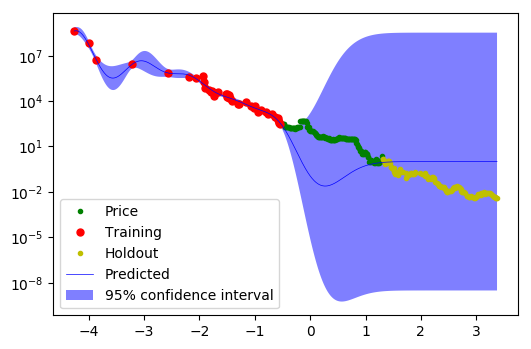

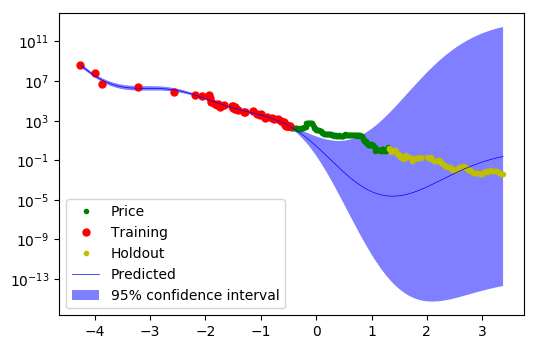

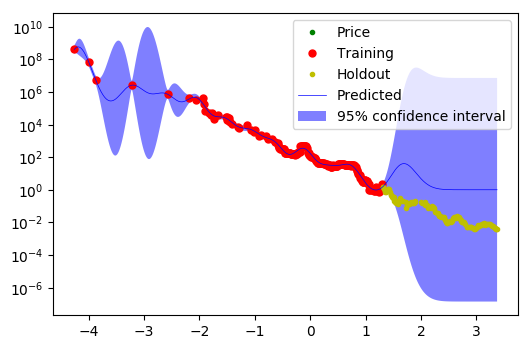

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load data, build train/test
ram_prices = pd.read_csv('data/ram_price.csv').sort_values(by='date')
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]
X_train = data_train.date[:, np.newaxis]
X_test = data_test.date[:, np.newaxis]

# we use a log-transform for the targets
y_train = np.log(data_train.price)
y_test = np.log(data_test.price)

# Scale features for GPs. StandardScaler 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add 5 observations at a time, then use full training set
for size in list(range(5, 50, 5)) + [len(X_train)]:
    X_sample, y_sample = X_train_scaled[:size], y_train[:size]
    x = np.atleast_2d(np.linspace(min(X_train_scaled), max(X_test_scaled), 1000)).T
    
    # Construct the GP
    # Default alpha values clearly cause overfitting. 0.1 works better for the small samples.
    # For the full training set, you could further increase it, e.g. to 0.5
    
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5,alpha=1e-1).fit(X_sample, y_sample)
    
    # Make the predictions
    y_pred, sigma = gp.predict(x, return_std=True)
    y_pred_upper = y_pred + 1.96*sigma
    y_pred_low = y_pred - 1.96*sigma

    # Plot the function, the prediction and the 95% confidence interval
    fig = plt.figure()
    plt.semilogy(scaler.transform(data_train.date), data_train.price, 'g.', label=u'Price')
    plt.semilogy(X_sample, np.exp(y_sample), 'r.', markersize=10, label=u'Training')
    plt.semilogy(scaler.transform(data_test.date), data_test.price, 'y.', label=u'Holdout')
    plt.semilogy(x, np.exp(y_pred), 'b-', label=u'Predicted')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([np.exp(y_pred_low),
                             np.exp(y_pred_upper)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.legend(loc='best')
    plt.show();